<a href="https://www.kaggle.com/code/youneseloiarm/mitsui-co-mljar-automl-with-lags-sub-02?scriptVersionId=260389215" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

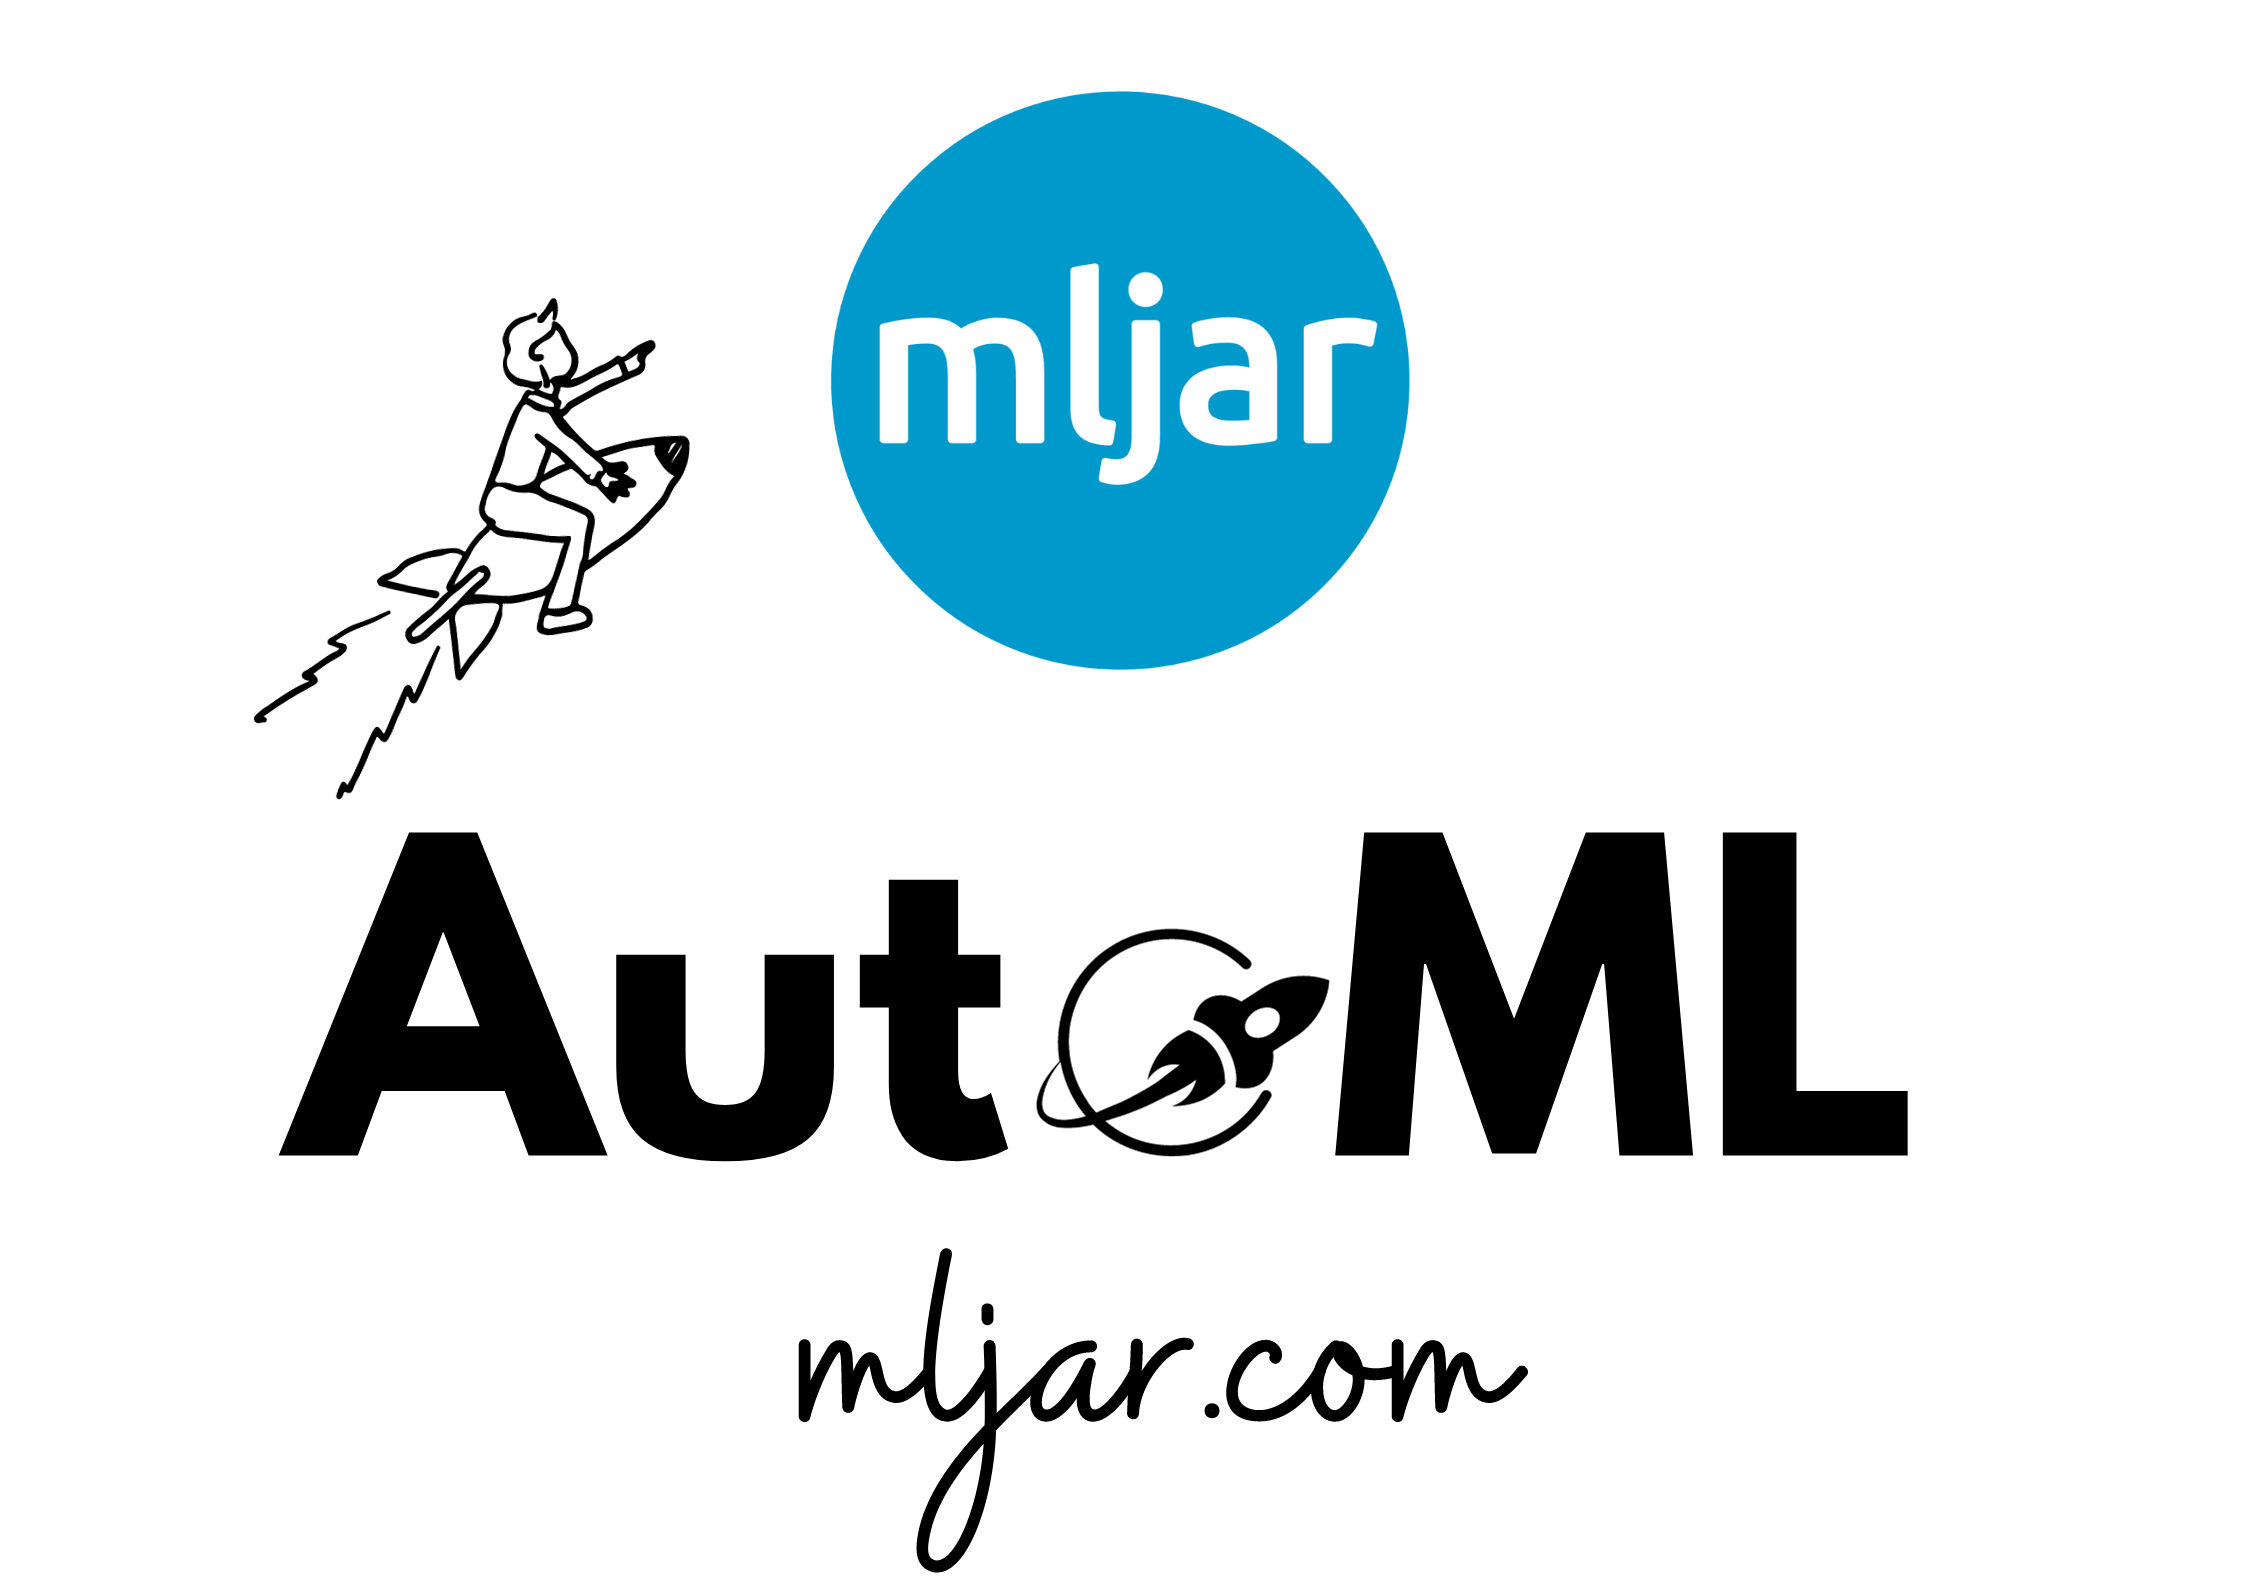

---

**In this notebook, we will use MLJAR AutoML for a multi-target regression problem, leveraging lagged targets to predict 424 outputs. To speed up inference, we adopt the long-format multi-output prediction method, which is much faster than the standard multi-output approach.**

**You will also find several useful techniques in this notebook, including:**

* How to create lagged targets and use them in the prediction step
* How to run AutoML models offline (without internet access)
* How to build an optimized prediction function for API inference



---

In [1]:
#!pip install mljar-supervised
!pip install --no-index --no-deps /kaggle/input/mljar-automl/wheelhouse/mljar_scikit_plot-0.3.12-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/mljar-automl/wheelhouse/mljar_supervised-1.1.18-py3-none-any.whl


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Processing /kaggle/input/mljar-automl/wheelhouse/mljar_scikit_plot-0.3.12-py3-none-any.whl
Processing /kaggle/input/mljar-automl/wheelhouse/mljar_supervised-1.1.18-py3-none-any.whl


In [2]:
!pip install --no-index --no-deps /kaggle/input/mljar-automl/wheelhouse/dtreeviz-2.2.2-py3-none-any.whl

Processing /kaggle/input/mljar-automl/wheelhouse/dtreeviz-2.2.2-py3-none-any.whl


In [3]:
!pip install --no-index --no-deps /kaggle/input/mljar-automl/wheelhouse/optuna_integration-4.4.0-py3-none-any.whl

Processing /kaggle/input/mljar-automl/wheelhouse/optuna_integration-4.4.0-py3-none-any.whl


In [4]:
from supervised.automl import AutoML
import kaggle_evaluation.mitsui_inference_server
from sklearn import *
import numpy as np
import pandas as pd
import polars as pl
import os, warnings
warnings.filterwarnings("ignore")

p = '/kaggle/input/mitsui-commodity-prediction-challenge/'
train = pd.read_csv(p+'train.csv')
trainl = pd.read_csv(p+'train_labels.csv')
traint = pd.read_csv(p+'target_pairs.csv')


In [5]:
trainl = trainl.fillna(0)

In [6]:
target_lag_1 = traint.loc[traint["lag"]==1,"target"].values
target_lag_2 = traint.loc[traint["lag"]==2,"target"].values
target_lag_3 = traint.loc[traint["lag"]==3,"target"].values
target_lag_4 = traint.loc[traint["lag"]==4,"target"].values

In [7]:
Features = [i for i in trainl.columns[1:] ]
def creat_lagged_labels(df):
    dt = pd.DataFrame()
    dt["date_id"] = df["date_id"]
    for f in Features:
        if f in target_lag_1:
            lag = 1
        elif f in target_lag_2:
            lag = 2
        elif f in target_lag_3:
            lag = 3
        elif f in target_lag_4:
            lag = 4    
        dt[f] = df[f].shift(lag).fillna(0)
    return df, dt

In [8]:
_,train_lagged = creat_lagged_labels(trainl)

In [9]:
train_lagged

,date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.005948,-0.002851,-0.004675,-0.000639,0.000000,0.000000,-0.006729,0.006066,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.005783,-0.024118,-0.007052,-0.018955,-0.031852,-0.019452,0.003002,-0.006876,-0.002042,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.001048,0.023836,-0.008934,-0.022060,0.000000,0.000000,0.037449,0.007658,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.001700,-0.024618,0.011943,0.004778,0.000000,0.000000,-0.012519,-0.016896,0.000000,...,0.000000,0.021239,-0.005595,0.000000,-0.004628,0.033793,0.000000,0.038234,0.000000,0.027310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,1956,0.002461,-0.000225,0.001229,-0.000627,0.000000,0.000000,-0.004208,0.007665,0.000000,...,0.000000,-0.006725,0.001344,0.000000,-0.050107,-0.017070,0.000000,-0.006722,0.000000,0.005249
1957,1957,0.002761,-0.004500,-0.001530,-0.003022,0.000000,0.000000,-0.006263,0.001251,0.000000,...,-0.000729,-0.008356,0.003985,0.012376,-0.043938,-0.013157,-0.000704,-0.035360,0.006352,0.006904
1958,1958,0.011424,-0.001036,0.000409,-0.003524,-0.008052,-0.013435,0.013214,-0.008121,0.005308,...,0.009382,-0.012275,0.012132,0.030011,-0.037556,-0.009914,0.005984,-0.022557,0.029302,0.011154
1959,1959,-0.002654,-0.002032,0.001083,0.004975,0.016810,0.020511,-0.003176,-0.002232,0.012985,...,-0.006255,0.005842,0.003945,-0.018496,-0.009460,-0.000114,-0.007490,-0.004104,-0.010907,-0.001935


In [10]:
trainl

,date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,0,0.005948,-0.002851,-0.004675,-0.000639,0.000000,0.000000,-0.006729,0.006066,0.000000,...,0.000000,0.021239,-0.005595,0.000000,-0.004628,0.033793,0.000000,0.038234,0.000000,0.027310
1,1,0.005783,-0.024118,-0.007052,-0.018955,-0.031852,-0.019452,0.003002,-0.006876,-0.002042,...,0.003377,0.021372,-0.001517,0.012846,0.010547,0.030527,-0.000764,0.025021,0.003548,0.020940
2,2,0.001048,0.023836,-0.008934,-0.022060,0.000000,0.000000,0.037449,0.007658,0.000000,...,-0.006712,0.009308,0.001857,-0.012761,-0.002345,0.017529,-0.005394,0.004835,-0.009075,0.001706
3,3,0.001700,-0.024618,0.011943,0.004778,0.000000,0.000000,-0.012519,-0.016896,0.000000,...,0.000000,0.036880,-0.015189,0.000000,0.008118,0.001079,0.000000,-0.015102,0.000000,-0.033010
4,4,-0.003272,0.005234,0.006856,0.013312,0.023953,0.010681,-0.011649,0.002019,0.003897,...,0.000000,0.004937,0.000000,-0.006673,-0.016105,-0.004885,0.000000,0.000000,0.009514,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,1956,0.002761,-0.004500,-0.001530,-0.003022,0.000000,0.000000,-0.006263,0.001251,0.000000,...,0.000000,0.010110,0.009248,0.000000,0.009526,0.004318,0.000000,0.005344,0.000000,-0.041391
1957,1957,0.011424,-0.001036,0.000409,-0.003524,-0.008052,-0.013435,0.013214,-0.008121,0.005308,...,-0.006012,-0.007567,0.021569,0.008000,0.015748,-0.001036,0.001043,0.015982,0.004550,-0.028627
1958,1958,-0.002654,-0.002032,0.001083,0.004975,0.016810,0.020511,-0.003176,-0.002232,0.012985,...,-0.026047,-0.007783,0.005746,-0.020410,0.026720,0.007130,0.004826,-0.002617,-0.033630,-0.007604
1959,1959,0.002124,-0.006335,-0.003885,0.002704,-0.004042,-0.001637,0.000142,-0.010872,-0.002934,...,-0.006359,-0.006478,0.012228,0.013633,0.022029,0.000092,0.016932,-0.000136,-0.006557,0.009290


In [11]:
train_lagged2 = train_lagged[-600:].copy()
trainl2 = trainl[-600:].copy()

In [12]:
# long-format multi-output predictions method:
import gc
training_df = []
target_cols = [f"target_{i}" for i in range(424)]
for j, target_col in enumerate(target_cols):
    temp_train_df = pd.DataFrame()
    temp_train_df[Features]  = train_lagged2[Features]                     
    #temp_train_df = X_trains2.copy()
    temp_train_df['target_id'] = j
    y = trainl2[target_col].values
    temp_train_df['target'] = y
    mask = ~(np.isnan(y) | np.isinf(y) | (np.abs(y) > 1e10))
    training_df.append(temp_train_df[mask].copy())
    del temp_train_df,y
    gc.collect()
training_df = pd.concat(training_df).reset_index(drop=True)

In [13]:
training_df.shape

(254400, 426)

In [14]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254400 entries, 0 to 254399
Columns: 426 entries, target_0 to target
dtypes: float64(425), int64(1)
memory usage: 826.8 MB


In [15]:
# Memory optimization
def reduce_memory_usage(df):
    """Optimize DataFrame memory usage by downcasting numeric columns."""
    start_mem = df.memory_usage().sum() / 1024**3
    print(f"Starting memory: {start_mem:.2f} GB")
    
    for col in df.select_dtypes(include=['float']).columns:
        col_min = df[col].min()
        col_max = df[col].max()
        
        if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
            df[col] = df[col].astype(np.float16)
        elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
            df[col] = df[col].astype(np.float32)
    
    end_mem = df.memory_usage().sum() / 1024**3
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f"Memory reduced to: {end_mem:.2f} GB ({reduction:.1f}% reduction)")
    return df
training_df = reduce_memory_usage(training_df)

Starting memory: 0.81 GB
Memory reduced to: 0.20 GB (74.8% reduction)


In [16]:
#train_data = h2o.H2OFrame(training_df)

In [17]:
#train_data.columns

In [18]:

# Example: training_df = pd.read_csv("your_data.csv")
label = "target"  # replace with your target column name
train_x = training_df.drop(columns=[label])
train_y = training_df[label]
automl = AutoML(results_path="/kaggle/input/mitsui-co-mljar-automl-with-lags-02/AutoML_1/")


In [19]:
#model.leaderboard

In [20]:
#model.leader

In [21]:
# Predictions
#preds = automl.predict(train_x)

In [22]:
#preds

In [23]:
#X_data = training_df.copy()
#X_data["preds"] = preds

In [24]:
#X_data[["target_id","preds"]]

```
# Step 1: Add row ID for test samples (0 to 89 repeated 424 times)
df_preds = X_data.copy()
df_preds['row'] = df_preds.groupby('target_id').cumcount()

# Step 2: Pivot the table to wide format
df_wide = df_preds.pivot(index='row', columns='target_id', values='preds')

# Step 3: Optionally, sort columns by target_id
df_wide = df_wide.sort_index(axis=1)
df_wide.index = [i for i in df_wide.index]
# Step 4: Rename columns (optional)
df_wide.columns = [f'target_{i}' for i in df_wide.columns]
df_wide
```

In [25]:
#/www.kaggle.com/code/metric/mitsui-co-commodity-prediction-metric
def rank_correlation_sharpe_ratio(merged_df: pd.DataFrame) -> float:
    prediction_cols = [col for col in merged_df.columns if col.startswith('prediction_')]
    target_cols = [col for col in merged_df.columns if col.startswith('target_')]
    def _compute_rank_correlation(row):
        non_null_targets = [col for col in target_cols if not pd.isnull(row[col])]
        matching_predictions = [col for col in prediction_cols if col.replace('prediction', 'target') in non_null_targets]
        if not non_null_targets:
            raise ValueError('No non-null target values found')
        if row[non_null_targets].std(ddof=0) == 0 or row[matching_predictions].std(ddof=0) == 0:
            raise ZeroDivisionError('Denominator is zero, unable to compute rank correlation.')
        return np.corrcoef(row[matching_predictions].rank(method='average'), row[non_null_targets].rank(method='average'))[0, 1]
    daily_rank_corrs = merged_df.apply(_compute_rank_correlation, axis=1)
    std_dev = daily_rank_corrs.std(ddof=0)
    if std_dev == 0:
        raise ZeroDivisionError('Denominator is zero, unable to compute Sharpe ratio.')
    sharpe_ratio = daily_rank_corrs.mean() / std_dev
    return float(sharpe_ratio)

def score(solution: pd.DataFrame, submission: pd.DataFrame) -> float:
    assert all(solution.columns == submission.columns)
    submission = submission.rename(columns={col: col.replace('target_', 'prediction_') for col in submission.columns})
    solution = solution.replace(0, None)
    return rank_correlation_sharpe_ratio(pd.concat([solution, submission], axis='columns'))

In [26]:
#df_wide.index = trainl2.index

In [27]:
#trainl2[Features[1:]]

In [28]:
#df_wide[Features[1:]]

In [29]:
#score(trainl2[Features[1:]],df_wide[Features[1:]])

In [30]:
ycols = ['target_' + str(i) for i in range(424)]
Features2 = [i for i in training_df.columns if i!="target"]

In [31]:
##automl
def predict(
    test: pl.DataFrame,
    lag1: pl.DataFrame, 
    lag2: pl.DataFrame,
    lag3: pl.DataFrame,
    lag4: pl.DataFrame,
) -> pl.DataFrame:
    """
    Predicts target values using lag features.
    Handles empty input and replaces null values with 0.
    Optimized for performance by:
    - Minimizing data conversions
    - Using vectorized operations
    - Reducing memory allocations
    - Parallelizing predictions where possible
    """
    # Combine lag features in one operation
    X_pred = pl.concat(
        [   test.select(["date_id"]),
            lag1.select(target_lag_1),
            lag2.select(target_lag_2),
            lag3.select(target_lag_3),
            lag4.select(target_lag_4),
        ],
        how="horizontal"
    )
    # If no rows, return all zeros
    if X_pred.height == 0:
        return pl.DataFrame(0, schema=[(f"target_{i}", pl.Float64) for i in range(424)])
    
    # Fill nulls with 0
    X_pred = X_pred.fill_null(0)
    # Prepare features for prediction in one go
    # Create all target_id combinations without materializing full DataFrame
    n_targets = 424
    n_rows = X_pred.height
    #print(X_pred[Features])
    # Prepare features for all targets at once
    features_array = np.tile(X_pred[Features].to_numpy(), (n_targets, 1))
    target_ids = np.repeat(np.arange(n_targets), n_rows)
    #print(Features)
    # Create final prediction DataFrame efficiently
    X_pred2 = pl.DataFrame({
       "date_id": np.tile(X_pred["date_id"].to_numpy(), n_targets),
       **{feat: features_array[:, i] for i, feat in enumerate(Features)},
       "target_id": target_ids,
       "row": np.tile(np.arange(n_rows), 424)
    })
    #print(X_pred2)
    # Predict in batches for memory efficiency
    #batch_size = 10000
    preds = np.zeros(len(X_pred2))
    #print(X_pred2[Features2])
    test_data = X_pred2[Features2].to_pandas()
    #print(test_data)
    predictions = automl.predict(test_data)
    #h2o_predictions_df = h2o_predictions.as_data_frame()
    #h2o_predictions_df.values
    X_pred2 = X_pred2.with_columns(pl.Series("preds", predictions))
    # Pivot to wide format more efficiently
    df_wide = (
        X_pred2.lazy()
        .group_by(["target_id", "row"])
        .agg(pl.col("preds").first())
        .collect()
        .pivot(index="row", columns="target_id", values="preds")
        .sort("row")
    )

    # Ensure correct column order by sorting by target_id
    col_order = sorted([col for col in df_wide.columns if col != "row"], key=int)
    df_wide = df_wide.select(["row"] + col_order)

    # Rename columns to target_0 ... target_423
    df_wide.columns = ["row"] + [f"target_{i}" for i in range(424)]
    # Get column names in order
    target_cols = [f"target_{i}" for i in range(424)]
    df_wide = df_wide.select(target_cols)
    #print(df_wide)
    # Return last row as predictions
    return df_wide.tail(1).to_pandas()

In [32]:
# submission through the API
import kaggle_evaluation.mitsui_inference_server
inference_server = kaggle_evaluation.mitsui_inference_server.MitsuiInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/mitsui-commodity-prediction-challenge/',))

In [33]:
display(pl.read_parquet('/kaggle/working/submission.parquet'))

date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,target_9,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19,target_20,target_21,target_22,target_23,target_24,target_25,target_26,target_27,target_28,target_29,target_30,target_31,target_32,target_33,target_34,target_35,…,target_387,target_388,target_389,target_390,target_391,target_392,target_393,target_394,target_395,target_396,target_397,target_398,target_399,target_400,target_401,target_402,target_403,target_404,target_405,target_406,target_407,target_408,target_409,target_410,target_411,target_412,target_413,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1827,0.000036,0.000091,0.000091,0.000091,0.000091,0.000091,0.000091,0.000091,0.000091,0.000107,0.000107,0.000145,0.000145,0.000121,0.000121,0.000161,0.000161,0.000095,0.000095,0.000098,0.000092,0.000041,0.00007,0.000058,0.000058,0.000058,0.000058,0.000202,0.000202,0.000032,-0.000096,-0.000096,-0.00006,-0.000004,-0.000004,-0.000004,…,-0.00045,-0.000457,-0.000456,-0.000452,-0.000456,-0.000422,-0.000416,-0.000421,-0.000421,-0.000421,-0.000116,-0.000416,-0.000416,-0.000416,-0.000403,-0.000403,-0.000352,-0.00012,0.000099,0.000137,-0.000128,-0.000009,0.000121,0.000079,0.000149,0.00018,0.000086,0.000036,-0.000044,0.000024,-0.00018,-0.000109,-0.000109,-0.000102,0.000331,0.000366,0.001514
1828,0.000036,0.000091,0.000091,0.000091,0.000091,0.000091,0.000091,0.000091,0.000091,0.000107,0.000107,0.000145,0.000145,0.000121,0.000121,0.000161,0.000161,0.000095,0.000095,0.000098,0.000092,0.000041,0.00007,0.000058,0.000058,0.000058,0.000058,0.000202,0.000202,0.000032,-0.000096,-0.000096,-0.00006,-0.000004,-0.000004,-0.000004,…,-0.00045,-0.000457,-0.000456,-0.000452,-0.000456,-0.000422,-0.000416,-0.000421,-0.000421,-0.000421,-0.000116,-0.000416,-0.000416,-0.000416,-0.000403,-0.000403,-0.000352,-0.00012,0.000099,0.000137,-0.000128,-0.000009,0.000121,0.000079,0.000149,0.00018,0.000086,0.000036,-0.000044,0.000024,-0.00018,-0.000109,-0.000109,-0.000102,0.000331,0.000366,0.001514
1829,-0.000029,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000122,0.000121,0.000121,0.000122,0.000116,0.000116,0.000123,0.000117,0.000117,0.000117,0.000117,0.000232,0.000232,-0.000008,-0.000087,-0.000087,-0.00006,-0.000028,-0.000028,-0.000028,…,-0.000435,-0.000439,-0.000435,-0.000435,-0.000438,-0.000404,-0.000398,-0.000403,-0.000403,-0.000403,0.000084,-0.000398,-0.000398,-0.000398,-0.000414,-0.000408,-0.000335,-0.000136,0.000107,0.000124,0.000075,0.000022,0.000036,0.000077,0.000049,0.000077,0.00008,0.000041,-0.00002,0.000025,-0.000141,-0.000033,-0.000071,0.000375,0.000403,0.000421,0.001581
1830,0.000276,0.000233,0.000233,0.000233,0.000233,0.000233,0.000233,0.000233,0.000233,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000233,0.000233,0.000241,0.000241,0.000239,0.000234,0.000253,0.000263,0.000271,0.000271,0.000244,0.000244,0.000314,0.000314,0.000259,0.000237,0.000237,0.000237,0.000228,0.000228,0.000228,…,-0.000497,-0.000712,-0.0002,-0.000244,-0.000437,-0.000448,-0.000282,-0.000478,-0.000249,-0.000432,-0.000029,-0.000254,-0.000183,-0.000247,-0.000205,0.000049,0.00103,0.000431,-0.000093,-0.000073,-0.000079,-0.000092,-0.00018,-0.00009,-0.00027,-0.000402,-0.00018,-0.000127,-0.00011,-0.000144,-0.000127,0.000191,-0.000274,-0.00027,-0.000411,0.000058,0.004025
1831,0.000227,0.000173,0.000174,0.000174,0.000173,0.000174,0.000174,0.000174,0.000174,0.000186,0.000186,0.000186,0.000186,0.000186,0.000186,0.000178,0.000178,0.000174,0.000174,0.000